In [54]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import h3
from math import prod
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [55]:
alpha = 0.1
models = ['leapfrog', 'chain', 'naive', 'fcfs', 'favorite leapfrog', 'favorite mix', 'favorite chain']
resolution = 4

# amewoo, buwtea, lobcur, tunswa, sursco, bkpwar, sheowl
species = 'bkpwar'

In [56]:
# disk radius
radius = 5
destination_radius = radius
departure_radius = radius

In [ ]:
# Define seasons with start and end (month, day)
season_definitions = {
    'snoowl1': {
        'breeding': {'start': (7, 6), 'end': (16, 8)},  
        'wintering': {'start': (6, 12), 'end': (1, 3)}  
    },
    'sheowl': {
        'breeding': {'start': (17, 5), 'end': (16, 8)},  
        'wintering': {'start': (6, 12), 'end': (22, 2)}  
    },
    'bkpwar': {
        'breeding': {'start': (14, 6), 'end': (2, 8)},  
        'wintering': {'start': (13, 12), 'end': (5, 4)}  
    },
    'sursco': {
        'breeding': {'start': (7, 6), 'end': (26, 7)},  
        'wintering': {'start': (20, 12), 'end': (22, 2)}  
    },
    'tunswa': {
        'breeding': {'start': (7, 6), 'end': (26, 7)},  # 7 июнь-26 июль
        'wintering': {'start': (27, 12), 'end': (15, 2)}  # 27 дек.-15 февр.
    },
    'buwtea': {
        'breeding': {'start': (14, 6), 'end': (12, 7)},  # 14 июнь - 12 июль
        'wintering': {'start': (27, 12), 'end': (25, 1)}  #27 дек. - 25 янв.
    },
    'lobcur': {
        'breeding': {'start': (10, 5), 'end': (7, 6)},  # 10 май-7 июнь
        'wintering': {'start': (6, 12), 'end': (8, 2)}  # 6 дек. - 8 февр.
    },
    'amewoo': None
}

In [ ]:
file_paths = {
    'snoowl1': 'snoowl1/Snowy owl - North America.csv',
    'sheowl': 'sheowl/Short-eared Owl, North America.csv',
    'bkpwar': 'bkpwar/Blackpoll Warbler eastern North America (data from DeLuca et al. 2015).csv',
    'sursco': 'sursco/surfScoter_USGS_ASC_argos.csv',
    'tunswa': 'tunswa/tundraSwan_USGS_ASC_argos.csv',
    'buwtea': 'buwtea/blueWingedTeal_USGS_ASC_argos.csv',
    'bubsan': 'bubsan/buffBreastedSandpiper_USGS_ASC_argosGPS.csv',
    'lobcur': 'lobcur/longBilledCurlew_USGS_ASC_argos.csv', 
    'amewoo': 'amewoo/USGS Woodcock Migration.csv'
}

In [59]:
df = pd.read_csv(file_paths[species])

/tmp/ipykernel_439314/516614534.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_paths[species])


In [60]:
df.head()

,event-id,visible,timestamp,location-long,location-lat,comments,gls:light-level,study-specific-measurement,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,1685863508,True,2013-06-14 04:50:00.000,-72.599244,44.010151,2.0,NaN,6/14/13 0:47:6/14/13 8:53,solar-geolocator,Setophaga,A,A,Blackpoll Warbler eastern North America (data ...
1,1685863509,True,2013-06-14 16:52:00.000,-73.112302,44.470903,1.0,NaN,6/14/13 8:53:6/15/13 0:51,solar-geolocator,Setophaga,A,A,Blackpoll Warbler eastern North America (data ...
2,1685863510,True,2013-06-15 04:51:00.000,-72.788699,44.746498,2.0,NaN,6/15/13 0:51:6/15/13 8:51,solar-geolocator,Setophaga,A,A,Blackpoll Warbler eastern North America (data ...
3,1685863511,True,2013-06-15 16:49:00.000,-72.246149,44.209171,1.0,NaN,6/15/13 8:51:6/16/13 0:47,solar-geolocator,Setophaga,A,A,Blackpoll Warbler eastern North America (data ...
4,1685863512,True,2013-06-16 04:47:00.000,-71.619430,44.775741,2.0,NaN,6/16/13 0:47:6/16/13 8:46,solar-geolocator,Setophaga,A,A,Blackpoll Warbler eastern North America (data ...


In [61]:
df.columns

Index(['event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
       'comments', 'gls:light-level', 'study-specific-measurement',
       'sensor-type', 'individual-taxon-canonical-name',
       'tag-local-identifier', 'individual-local-identifier', 'study-name'],
      dtype='object')

In [62]:
def is_date_in_season(date, season_start, season_end):
    """
    Check if a date falls within a season, handling seasons that cross year boundaries.
    
    Parameters:
    date: pandas Timestamp
    season_start: tuple (day, month)
    season_end: tuple (day, month)
    
    Returns:
    bool: True if date is in season
    """
    year = date.year
    start_date = pd.Timestamp(year, season_start[1], season_start[0])
    end_date = pd.Timestamp(year, season_end[1], season_end[0])
    
    # Handle seasons that cross year boundaries (e.g., Nov-Feb)
    if start_date > end_date:
        # Season crosses year boundary
        if date >= start_date or date <= end_date:
            return True
    else:
        # Normal season within same year
        if start_date <= date <= end_date:
            return True
    
    return False


In [63]:
if 'migration-stage' not in df.columns:
    # Parse timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Get season definitions for this species
    seasons = season_definitions.get(species, {})
    print(seasons)
    breeding_season = seasons['breeding']
    wintering_season = seasons['wintering']
    
    # Assign migration-stage based on date ranges
    df['migration-stage'] = 'None'  # initialize
    
    # Check for breeding season
    breeding_mask = df['timestamp'].apply(
        lambda x: is_date_in_season(x, breeding_season['start'], breeding_season['end'])
    )
    df.loc[breeding_mask, 'migration-stage'] = 'breeding'
    
    # Check for wintering season
    wintering_mask = df['timestamp'].apply(
        lambda x: is_date_in_season(x, wintering_season['start'], wintering_season['end'])
    )
    df.loc[wintering_mask, 'migration-stage'] = 'wintering'
    
    # Handle overlap cases
    overlap_mask = breeding_mask & wintering_mask
    if overlap_mask.any():
        print(f"Warning: {overlap_mask.sum()} records fall in both breeding and wintering seasons")

{'breeding': {'start': (14, 6), 'end': (2, 8)}, 'wintering': {'start': (13, 12), 'end': (5, 4)}}


In [64]:
df['migration-stage'].value_counts()

migration-stage
None         503498
wintering    289125
breeding     117591
Name: count, dtype: int64

In [65]:
df = df[['visible', 'location-long', 'location-lat', 'migration-stage', 'individual-local-identifier']]

In [66]:
df = df[df['visible'] == True].drop(columns=['visible'])
df = df.dropna()

In [67]:
print(df['individual-local-identifier'].unique())
print(len(df['individual-local-identifier'].unique()))

['A' 'B' 'C' 'D' 'E']
5


In [68]:
indiv = df[
    (df['individual-local-identifier'] == df['individual-local-identifier'].iloc[0])
]


In [69]:
print(indiv['migration-stage'].unique())

['breeding' 'None' 'wintering']


In [70]:
print(indiv)

     location-long  location-lat migration-stage individual-local-identifier
0       -72.599244     44.010151        breeding                           A
1       -73.112302     44.470903        breeding                           A
2       -72.788699     44.746498        breeding                           A
3       -72.246149     44.209171        breeding                           A
4       -71.619430     44.775741        breeding                           A
..             ...           ...             ...                         ...
703     -72.852963     45.993383            None                           A
704     -72.328687     46.394434            None                           A
705     -72.888761     46.819096            None                           A
706     -73.328689     46.335058            None                           A
707     -71.313378     44.317275            None                           A

[674 rows x 4 columns]


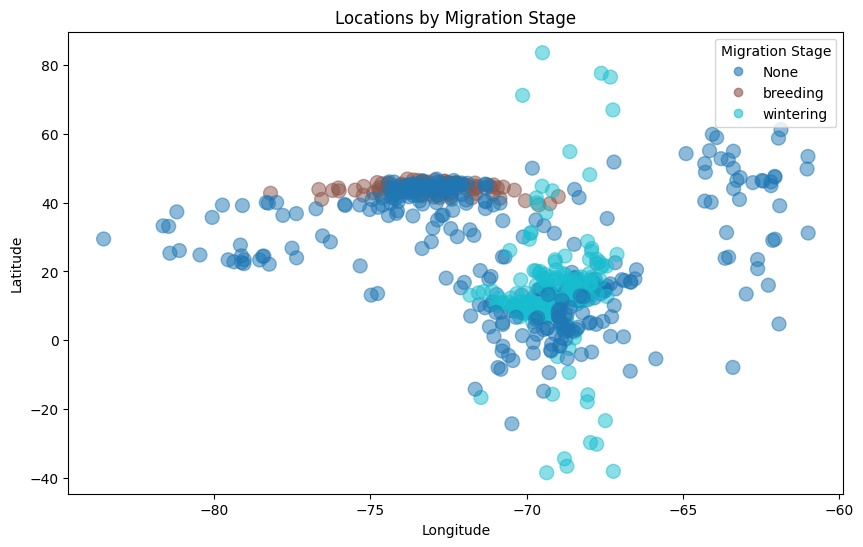

In [71]:
# Assign a color to each migration stage
stages = indiv['migration-stage'].astype('category')
colors = stages.cat.codes

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    indiv['location-long'], 
    indiv['location-lat'], 
    c=colors, 
    cmap='tab10', 
    alpha=0.5, 
    s=100,
    norm=plt.Normalize(vmin=colors.min(), vmax=colors.max())
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations by Migration Stage')
# Add legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, stages.cat.categories, title="Migration Stage")

plt.savefig(f"{species}/plots/indiv_locations.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [72]:
# Filter migration stages starting with 'b' and 'w'
df_bw = (df[df['migration-stage'].str.startswith(('b', 'w'))]).copy()

# Group by individual-local-identifier and migration-stage prefix
df_bw.loc[:, 'stage_prefix'] = df_bw['migration-stage'].str[0]
routes = df_bw.groupby(['individual-local-identifier', 'stage_prefix'])[['location-long', 'location-lat']].mean().unstack()

# Rename columns for clarity
routes.columns = ['avg_long_b', 'avg_long_w', 'avg_lat_b', 'avg_lat_w']
routes = routes.reset_index()

In [73]:
routes = routes.dropna()
len(routes)

4

In [74]:
routes.head()

,individual-local-identifier,avg_long_b,avg_long_w,avg_lat_b,avg_lat_w
0,A,-73.059016,-69.274978,44.139799,12.830276
1,B,-72.922860,-71.990892,43.921076,14.654715
2,C,-65.975586,-69.144635,43.234879,12.359190
4,E,-72.990052,-72.105799,43.514221,16.397969


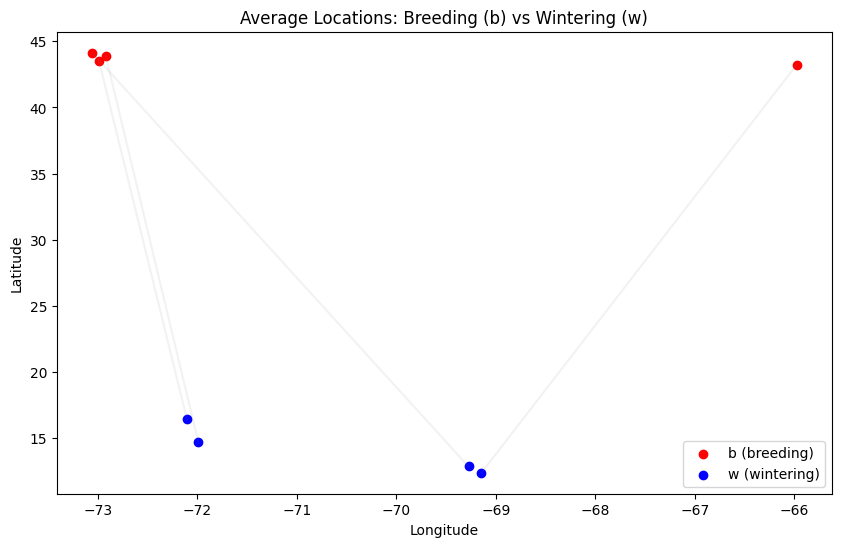

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(routes['avg_long_b'], routes['avg_lat_b'], color='red', label='b (breeding)')
plt.scatter(routes['avg_long_w'], routes['avg_lat_w'], color='blue', label='w (wintering)')

# Draw lines connecting breeding and wintering locations for each individual
for _, row in routes.iterrows():
    plt.plot([row['avg_long_b'], row['avg_long_w']], [row['avg_lat_b'], row['avg_lat_w']], color='gray', alpha=0.1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Locations: Breeding (b) vs Wintering (w)')
plt.legend()

plt.savefig(f"{species}/plots/real_routes.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [76]:
routes['cell_b'] = routes.apply(lambda row: h3.latlng_to_cell(row['avg_lat_b'], row['avg_long_b'], resolution), axis=1)
routes['cell_w'] = routes.apply(lambda row: h3.latlng_to_cell(row['avg_lat_w'], row['avg_long_w'], resolution), axis=1)

In [77]:
print(routes['cell_w'].iloc[0])
print(routes['cell_b'].iloc[0])

846773bffffffff
842b8ddffffffff


In [78]:
routes.columns

Index(['individual-local-identifier', 'avg_long_b', 'avg_long_w', 'avg_lat_b',
       'avg_lat_w', 'cell_b', 'cell_w'],
      dtype='object')

In [79]:
# probabilities = routes.merge(
#     flow_leapfrog[['departure_cell', 'destination_cell', 'probability']],
#     left_on=['cell_w', 'cell_b'],
#     right_on=['departure_cell', 'destination_cell'],
#     how='left'
# )
# probabilities = probabilities[['departure_cell', 'destination_cell', 'probability']]

In [80]:
# probabilities.dropna().head()

In [81]:
# def departure_aggretation(flow, departure_radius):
#     flow_copy = flow.copy()
    
#     for row in flow.itertuples(index=True):
#         neighbors = h3.grid_disk(row.departure_cell, departure_radius)
        
#         flow_copy.at[row.Index, 'flow'] = 0
#         flow_copy.at[row.Index, 'departure_value'] = 0
#         for neighbor in neighbors:
#             match = flow[
#                 (flow['departure_cell'] == neighbor) &
#                 (flow['destination_cell'] == row.destination_cell)
#             ]
#             flow_copy.at[row.Index, 'flow'] += match.iloc[0].flow if not match.empty else 0
#             flow_copy.at[row.Index, 'departure_value'] += match.iloc[0].departure_value if not match.empty else 0

#         flow_copy.at[row.Index, 'probability'] = flow_copy.at[row.Index, 'flow'] / flow_copy.at[row.Index, 'departure_value']
    
#     return flow_copy


In [82]:
# def calculate_probabilities(routes, flow, destination_radius):
#     df = routes.copy()
#     df['probability'] = None
#     for row in df.itertuples(index=True):
#         neighbors = h3.grid_disk(row.cell_b, destination_radius)
        
#         df.at[row.Index, 'probability'] = 0
#         for neighbor in neighbors:
#             match = flow[
#                 (flow['departure_cell'] == row.cell_w) &
#                 (flow['destination_cell'] == neighbor)
#             ]
#             df.at[row.Index, 'probability'] += match.iloc[0].probability if not match.empty else 0
    
#     return df

In [83]:
# TODO точно можно оптимизировать чтобы каждую точку много раз не обрабатывать
# сейчас сложность O(N*M) мне кажется можно сделать как-то O(N)

In [84]:
def departure_aggregation(flow: pd.DataFrame, departure_radius: int) -> pd.DataFrame:
    """
    Aggregates flows by expanding departure cells within a given radius.
    Mutates `flow` in place: updates flow, departure_value, and probability.
    """

    # Build lookup dict for fast access: (dep, dest) → (flow, departure_value)
    flow_lookup = {
        (dep, dest): (f, dv)
        for dep, dest, f, dv in flow[['departure_cell', 'destination_cell', 'flow', 'departure_value']].itertuples(index=False)
    }

    # Reset target columns in place
    flow['flow'] = 0.0
    flow['departure_value'] = 0.0
    flow['probability'] = 0.0

    for row in flow.itertuples(index=True):
        neighbors = h3.grid_disk(row.departure_cell, departure_radius)

        total_flow, total_dep_val = 0.0, 0.0
        for neighbor in neighbors:
            match = flow_lookup.get((neighbor, row.destination_cell))
            if match:
                f, dv = match
                total_flow += f
                total_dep_val += dv

        flow.at[row.Index, 'flow'] = total_flow
        flow.at[row.Index, 'departure_value'] = total_dep_val
        flow.at[row.Index, 'probability'] = total_flow / total_dep_val if total_dep_val != 0 else 0

def calculate_probabilities(routes: pd.DataFrame, flow: pd.DataFrame, destination_radius: int) -> pd.DataFrame:
    """
    Computes probabilities for routes by summing probabilities of flows
    whose destinations are within the given radius of the route destination.
    Mutates `routes` in place: adds/updates 'probability' column.
    """

    # Build lookup dict: (dep, dest) → probability
    prob_lookup = {
        (dep, dest): p
        for dep, dest, p in flow[['departure_cell', 'destination_cell', 'probability']].itertuples(index=False)
    }

    # Initialize/overwrite probability column in place
    routes['probability'] = 0.0

    for row in routes.itertuples(index=True):
        neighbors = h3.grid_disk(row.cell_b, destination_radius)

        total_prob = 0
        for neighbor in neighbors:
            total_prob += prob_lookup.get((row.cell_w, neighbor), 0)

        routes.at[row.Index, 'probability'] = total_prob

In [85]:
flow_leapfrog = pd.read_csv(f'{species}/tables/leapfrog/leapfrog_{alpha}.csv')
probabilities_lf = routes.copy()
departure_aggregation(flow_leapfrog, departure_radius)
calculate_probabilities(probabilities_lf, flow_leapfrog, destination_radius)
routes['leapfrog'] = probabilities_lf['probability'].values

probabilities_lf.probability[probabilities_lf.probability > 0]

Series([], Name: probability, dtype: float64)

In [86]:
flow_chain = pd.read_csv(f'{species}/tables/chain/chain_{alpha}.csv')
probabilities_chain = routes.copy()
departure_aggregation(flow_chain, departure_radius)
calculate_probabilities(probabilities_chain, flow_chain, destination_radius)
routes['chain'] = probabilities_chain['probability'].values

probabilities_chain.probability[probabilities_chain.probability > 0]

Series([], Name: probability, dtype: float64)

In [ ]:
flow_naive = pd.read_csv(f'{species}/tables/naive/naive_{alpha}.csv')
probabilities_naive = routes.copy()
departure_aggregation(flow_naive, departure_radius)
calculate_probabilities(probabilities_naive, flow_naive, destination_radius)
routes['naive'] = probabilities_naive['probability'].values

probabilities_naive.probability[probabilities_naive.probability > 0]

In [ ]:
flow_fcfs = pd.read_csv(f'{species}/tables/fcfs/fcfs_{alpha}.csv')
probabilities_fcfs = routes.copy()
departure_aggregation(flow_fcfs, departure_radius)
calculate_probabilities(probabilities_fcfs, flow_fcfs, destination_radius)
routes['fcfs'] = probabilities_fcfs['probability'].values

probabilities_fcfs.probability[probabilities_fcfs.probability > 0]

0     1.029747e-03
4     1.443483e-06
10    5.588524e-04
11    1.519548e-02
12    4.127185e-05
13    2.157637e-25
14    1.290137e-02
15    6.046972e-08
16    1.092110e-11
Name: probability, dtype: float64

In [ ]:
flow_flp = pd.read_csv(f'{species}/tables/favorite leapfrog/favorite leapfrog_{alpha}.csv')
probabilities_flp = routes.copy()
departure_aggregation(flow_flp, departure_radius)
calculate_probabilities(probabilities_flp, flow_flp, destination_radius)
routes['favorite leapfrog'] = probabilities_flp['probability'].values

probabilities_flp.probability[probabilities_flp.probability > 0]

4     1.900000e-01
10    1.131858e-06
11    3.347453e-06
12    7.828199e-06
13    3.819223e-19
14    1.129347e-05
15    9.316268e-06
16    4.866076e-06
Name: probability, dtype: float64

In [ ]:
flow_fch = pd.read_csv(f'{species}/tables/favorite chain/favorite chain_{alpha}.csv')
probabilities_fch = routes.copy()
departure_aggregation(flow_fch, departure_radius)
calculate_probabilities(probabilities_fch, flow_fch, destination_radius)
routes['favorite chain'] = probabilities_fch['probability'].values

probabilities_fch.probability[probabilities_fch.probability > 0]

0     1.430337e-07
4     3.046219e-06
10    8.382882e-03
11    4.950733e-02
12    4.364578e-04
13    4.066994e-03
14    8.582895e-02
15    2.132597e-02
Name: probability, dtype: float64

In [ ]:
flow_fm = pd.read_csv(f'{species}/tables/favorite mix/favorite mix_{alpha}.csv')
probabilities_fm = routes.copy()
departure_aggregation(flow_fm, departure_radius)
calculate_probabilities(probabilities_fm, flow_fm, destination_radius)
routes['favorite mix'] = probabilities_fm['probability'].values

probabilities_fm.probability[probabilities_fm.probability > 0]

0     0.141112
4     0.290337
10    0.000001
11    0.000003
12    0.000008
14    0.000011
15    0.000009
16    0.000005
Name: probability, dtype: float64

In [ ]:
routes.head()

,individual-local-identifier,avg_long_b,avg_long_w,avg_lat_b,avg_lat_w,cell_b,cell_w,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite chain,favorite mix
0,SUSC2005_782052,-112.835000,-115.552286,62.200190,29.979429,8413539ffffffff,8448435ffffffff,0.000000e+00,0.000000e+00,0.035157,0.001030,0.000000,1.430337e-07,0.141112
4,SUSC2006_782077,-135.140113,-115.963769,58.289198,30.407308,8413933ffffffff,8448437ffffffff,1.895781e-01,1.895781e-01,0.426763,0.000001,0.190000,3.046219e-06,0.290337
10,SUSC2008_700818,-127.625711,-128.498877,68.037711,51.759140,841331dffffffff,841298dffffffff,3.616673e-11,3.616673e-11,0.018864,0.000559,0.000001,8.382882e-03,0.000001
11,SUSC2008_700826,-131.728475,-134.732066,69.369283,58.307736,840d659ffffffff,84139edffffffff,9.212143e-18,9.212143e-18,0.049443,0.015195,0.000003,4.950733e-02,0.000003
12,SUSC2008_700831,-144.074077,-134.708165,67.420154,58.309235,840d467ffffffff,84139edffffffff,7.226176e-12,7.226176e-12,0.007444,0.000041,0.000008,4.364578e-04,0.000008


In [ ]:
probs = routes[models].astype(float)

routes['best_model'] = np.where(
    ((probs < 0.01).all(axis=1)) & (~(probs == 0).all(axis=1)),
    'prob < 0.01',
    np.where(
        (probs == 0).all(axis=1),
        'no abundance data',
        probs.idxmax(axis=1)
    )
)

In [ ]:
routes.head()

,individual-local-identifier,avg_long_b,avg_long_w,avg_lat_b,avg_lat_w,cell_b,cell_w,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite chain,favorite mix,best_model
0,SUSC2005_782052,-112.835000,-115.552286,62.200190,29.979429,8413539ffffffff,8448435ffffffff,0.000000e+00,0.000000e+00,0.035157,0.001030,0.000000,1.430337e-07,0.141112,favorite mix
4,SUSC2006_782077,-135.140113,-115.963769,58.289198,30.407308,8413933ffffffff,8448437ffffffff,1.895781e-01,1.895781e-01,0.426763,0.000001,0.190000,3.046219e-06,0.290337,naive
10,SUSC2008_700818,-127.625711,-128.498877,68.037711,51.759140,841331dffffffff,841298dffffffff,3.616673e-11,3.616673e-11,0.018864,0.000559,0.000001,8.382882e-03,0.000001,naive
11,SUSC2008_700826,-131.728475,-134.732066,69.369283,58.307736,840d659ffffffff,84139edffffffff,9.212143e-18,9.212143e-18,0.049443,0.015195,0.000003,4.950733e-02,0.000003,favorite chain
12,SUSC2008_700831,-144.074077,-134.708165,67.420154,58.309235,840d467ffffffff,84139edffffffff,7.226176e-12,7.226176e-12,0.007444,0.000041,0.000008,4.364578e-04,0.000008,prob < 0.01


In [ ]:
routes.to_csv(f'{species}/tables/routes_likelihood.csv', index = False)

In [ ]:
# routes = pd.read_csv(f'{species}/tables/routes_likelihood.csv')

In [ ]:
zero_mask = routes[models] == 0
zero_mask.head()

,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite mix,favorite chain
0,True,True,False,False,True,False,False
4,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False


In [ ]:
zero_mask.sum(axis=0)

leapfrog             1
chain                1
naive                0
fcfs                 0
favorite leapfrog    1
favorite mix         1
favorite chain       1
dtype: int64

In [ ]:
non_zero_rows = ~zero_mask.any(axis=1)
routes.loc[non_zero_rows, models].prod(axis=0)

leapfrog             4.213949e-67
chain                4.213949e-67
naive                1.919469e-09
fcfs                 3.946853e-25
favorite leapfrog    5.929131e-28
favorite mix         9.060341e-28
favorite chain       1.009971e-15
dtype: float64

In [ ]:
model_colors = {
    'leapfrog': 'green', 
    'chain': 'purple', 
    'naive': 'pink', 
    'fcfs': 'orange',
    'favorite leapfrog': 'cyan', 
    'favorite chain': 'midnightblue', 
    'favorite mix': 'yellow',
    'prob < 0.01': 'gray', 
    'no abundance data': 'lightgray'
    }

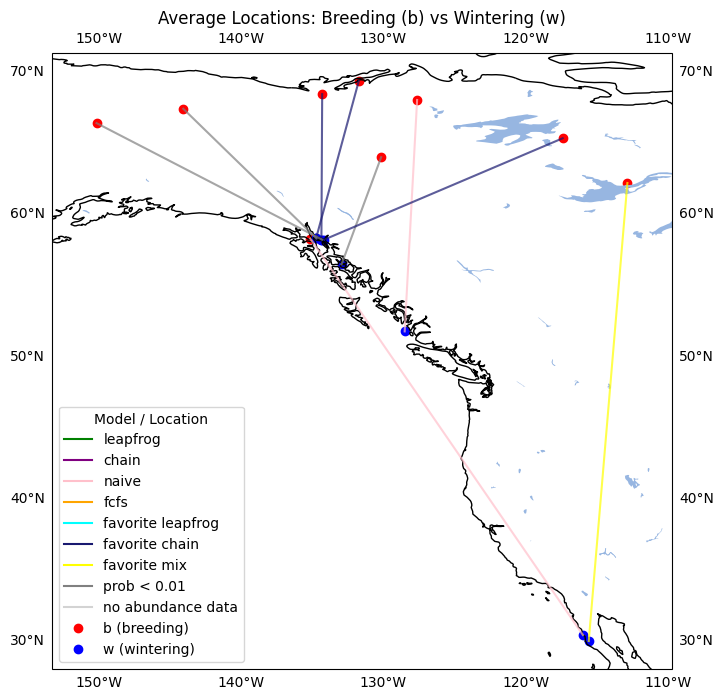

In [ ]:
# TODO fix this

# Create a figure and axis with Cartopy projection, set square aspect
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 8))

# Add coastlines and countries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
gl = ax.gridlines(draw_labels=True)
gl.xlines = False  # turn off vertical lines
gl.ylines = False  # turn off horizontal lines

ax.scatter(routes['avg_long_b'], routes['avg_lat_b'], color='red', label='b (breeding)')
ax.scatter(routes['avg_long_w'], routes['avg_lat_w'], color='blue', label='w (wintering)')

# Draw lines connecting breeding and wintering locations for each individual
for _, row in routes.iterrows():
    ax.plot(
        [row['avg_long_b'], row['avg_long_w']],
        [row['avg_lat_b'], row['avg_lat_w']],
        color=model_colors.get(row['best_model'], 'black'),
        alpha=0.7
    )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Locations: Breeding (b) vs Wintering (w)')

# Custom legend for line colors
import matplotlib.lines as mlines
handles = [
    mlines.Line2D([], [], color=color, label=model)
    for model, color in model_colors.items()
]
ax.legend(handles=handles + [
    mlines.Line2D([], [], color='red', marker='o', linestyle='', label='b (breeding)'),
    mlines.Line2D([], [], color='blue', marker='o', linestyle='', label='w (wintering)')
], title="Model / Location")

# Set aspect to be square
ax.set_aspect('equal', adjustable='datalim')

plt.savefig(f"{species}/plots/best_model_{radius}_.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [53]:
routes.tail(20)

,individual-local-identifier,avg_long_b,avg_long_w,avg_lat_b,avg_lat_w,cell_b,cell_w,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite chain,favorite mix,best_model
0,SUSC2005_782052,-112.835000,-115.552286,62.200190,29.979429,8413539ffffffff,8448435ffffffff,0.000000e+00,0.000000e+00,0.035157,1.029747e-03,0.000000e+00,1.430337e-07,0.141112,favorite mix
4,SUSC2006_782077,-135.140113,-115.963769,58.289198,30.407308,8413933ffffffff,8448437ffffffff,1.895781e-01,1.895781e-01,0.426763,1.443483e-06,1.900000e-01,3.046219e-06,0.290337,naive
10,SUSC2008_700818,-127.625711,-128.498877,68.037711,51.759140,841331dffffffff,841298dffffffff,3.616673e-11,3.616673e-11,0.018864,5.588524e-04,1.131858e-06,8.382882e-03,0.000001,naive
11,SUSC2008_700826,-131.728475,-134.732066,69.369283,58.307736,840d659ffffffff,84139edffffffff,9.212143e-18,9.212143e-18,0.049443,1.519548e-02,3.347453e-06,4.950733e-02,0.000003,favorite chain
12,SUSC2008_700831,-144.074077,-134.708165,67.420154,58.309235,840d467ffffffff,84139edffffffff,7.226176e-12,7.226176e-12,0.007444,4.127185e-05,7.828199e-06,4.364578e-04,0.000008,prob < 0.01
13,SUSC2008_700838,-130.154000,-132.940800,64.016500,56.476740,8413127ffffffff,8412b41ffffffff,2.179724e-04,2.179724e-04,0.000780,2.157637e-25,3.819223e-19,4.066994e-03,0.000000,prob < 0.01
14,SUSC2009_700161,-134.302398,-134.357686,68.449434,58.214271,840d619ffffffff,84139e1ffffffff,2.314586e-13,2.314586e-13,0.043882,1.290137e-02,1.129347e-05,8.582895e-02,0.000011,favorite chain
15,SUSC2009_700201,-117.386651,-134.159422,65.345339,58.216215,8413089ffffffff,84139e1ffffffff,3.988865e-15,3.988865e-15,0.014763,6.046972e-08,9.316268e-06,2.132597e-02,0.000009,favorite chain
16,SUSC2009_700205,-150.176338,-134.304500,66.412248,58.212080,840d53dffffffff,84139e1ffffffff,2.639668e-13,2.639668e-13,0.005259,1.092110e-11,4.866076e-06,0.000000e+00,0.000005,prob < 0.01


In [133]:
df_amewoo = pd.read_csv('/home/gkim/birds/lobcur/tables/routes_likelihood.csv')

In [134]:
df_amewoo

 

,individual-local-identifier,avg_long_b,avg_long_w,avg_lat_b,avg_lat_w,cell_b,cell_w,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite chain,favorite mix,best_model
0,LBCU_2007_Y2,-115.218690,-119.277380,40.704335,36.032155,84299bbffffffff,8429a8dffffffff,3.945648e-01,0.000000e+00,0.093371,8.297688e-02,2.387124e-01,0.116894,2.387124e-01,leapfrog
1,LBCU_2007_Y4,-115.224561,-113.983000,40.700985,31.606750,84299bbffffffff,84485e3ffffffff,0.000000e+00,7.143121e-01,0.093371,1.596461e-02,2.984631e-19,0.413827,5.783589e-14,chain
2,LBCU_2007_Z0,-119.726639,-121.480146,45.787625,38.374179,84288d5ffffffff,8428305ffffffff,3.972741e-02,0.000000e+00,0.024389,7.685615e-09,4.475380e-02,0.000000,4.475380e-02,favorite leapfrog
3,LBCU_2007_Z3,-119.678156,-120.927857,45.785059,37.398871,84288d5ffffffff,8428369ffffffff,9.976518e-03,0.000000e+00,0.024389,2.140721e-08,3.843146e-02,0.059179,3.843146e-02,favorite chain
4,LBCU_2007_Z6,-115.184793,-116.027304,40.746719,30.514052,84299bbffffffff,8448437ffffffff,0.000000e+00,1.202315e+00,0.093371,1.791402e-02,6.283744e-19,1.048827,9.706195e-14,chain
5,LBCU_2007_Z8,-115.219560,-114.231397,40.691260,27.742996,84299bbffffffff,844873bffffffff,0.000000e+00,8.419636e-02,0.093371,1.624664e-01,8.350598e-20,0.386178,2.739054e-15,favorite chain
6,LBCU_2007_Z9,-115.181826,-115.024094,40.745604,32.502821,84299bbffffffff,84485b9ffffffff,0.000000e+00,1.294397e-01,0.093371,4.247899e-02,3.525025e-19,0.034756,3.663359e-14,chain
7,LBCU_2008_D5,-119.673497,-120.022796,45.782723,36.270680,84288d5ffffffff,8429a83ffffffff,1.090578e-02,0.000000e+00,0.024389,5.714764e-08,3.082047e-02,0.056314,3.082047e-02,favorite chain
8,LBCU_2008_D6,-119.713168,-119.986328,45.791822,35.647690,84288d5ffffffff,8429a89ffffffff,8.337700e-03,1.582024e-02,0.024389,7.932627e-08,2.520972e-02,0.049489,2.520972e-02,favorite chain
9,LBCU_2008_D7,-119.706320,-121.444667,45.782714,36.917679,84288d5ffffffff,8429a93ffffffff,1.072808e-02,0.000000e+00,0.024389,2.714785e-08,3.048776e-02,0.057404,3.048776e-02,favorite chain


In [135]:
models = ['leapfrog', 'chain', 'naive', 'fcfs', 'favorite leapfrog', 'favorite mix', 'favorite chain']

In [136]:
zero_mask = df_amewoo[models] == 0
zero_mask.head()

,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite mix,favorite chain
0,False,True,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,True,False,False,False,False,True
3,False,True,False,False,False,False,False
4,True,False,False,False,False,False,False


In [137]:
zero_mask

,leapfrog,chain,naive,fcfs,favorite leapfrog,favorite mix,favorite chain
0,False,True,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,True,False,False,False,False,True
3,False,True,False,False,False,False,False
4,True,False,False,False,False,False,False
5,True,False,False,False,False,False,False
6,True,False,False,False,False,False,False
7,False,True,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,True,False,False,False,False,False


In [132]:
zero_mask.sum(axis=0)

leapfrog             39
chain                22
naive                 0
fcfs                  2
favorite leapfrog     8
favorite mix         12
favorite chain        7
dtype: int64

In [124]:
non_zero_rows = ~zero_mask.any(axis=1)
df_amewoo.loc[non_zero_rows, models].prod(axis=0)

leapfrog             6.010160e-03
chain                2.764855e-14
naive                3.770170e-08
fcfs                 3.423816e-06
favorite leapfrog    5.900142e-11
favorite mix         6.116085e-10
favorite chain       4.617345e-28
dtype: float64

In [125]:
len(df_amewoo)

50